## Notebook: Analyze and Visualize Pair Statistics

### Purpose
This notebook analyzes pair statistics from various datasets and visualizes key metrics.



In [1]:
## Imports and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
scene_name = "campus"
# Global configuration
BASE_PATH = "results_campusv1"
TYPES = ['mast3r', 'lidar', 'mast3r_scaled_v3', 'mast3r_scaled_v4', 'mast3r_scaled_icp']
BIN_WIDTH = 100

In [2]:
from my_utils.evaluate import load_statistics
    
loaded_data = {}
for pointcloud_type in TYPES:
    df = load_statistics(pointcloud_type, BASE_PATH, scene_name=scene_name)
    if df is not None:
        # Convert numeric columns
        numeric_columns = ["num_matches", "num_inliers", "num_overlapping", "median_depth", 
                           "x_error", "y_error", "z_error", "pos_error", "rot_error", 
                           "distance_anchor_query","pointmap_error"]
        scale_cols = [col for col in df.columns if col.startswith("scale")]
        numeric_columns.extend(scale_cols)

        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")
        
        loaded_data[pointcloud_type] = df

Loaded statistics for mast3r: 14 columns detected
Loaded statistics for lidar: 13 columns detected
Loaded statistics for mast3r_scaled_v3: 15 columns detected
Loaded statistics for mast3r_scaled_v4: 17 columns detected
Loaded statistics for mast3r_scaled_icp: 15 columns detected


In [ ]:
# # Define the dataset and threshold
# dataset_to_analyze = 'lidar'
# pos_error_threshold = 0.5  # Set your desired threshold

# # Get the dataset
# df = loaded_data[dataset_to_analyze]
# df_ok = df[df['status'] == 'OK']  # Filter for successful pairs

# # Filter for pairs below the threshold
# pairs_below_threshold = df_ok[df_ok['pos_error'] < pos_error_threshold]

# # Count the number of pairs
# num_pairs_below_threshold = len(pairs_below_threshold)

# print(f"Number of pairs in {dataset_to_analyze} with pos_error below {pos_error_threshold}: {num_pairs_below_threshold}")

# # Display the pairs and their statistics
# if num_pairs_below_threshold > 0:
#     print("\nPairs and their statistics:")
#     relevant_columns = ['query_seq', 'anchor_seq', 'query_idx', 'anchor_idx', 
#                         'num_matches', 'num_inliers', 'num_overlapping', 
#                         'pos_error', 'distance_anchor_query', 'median_depth']
#     print(pairs_below_threshold[relevant_columns].to_string(index=False))
# else:
#     print("No pairs found below the specified pos_error threshold.")

In [4]:
# top3_path = "/home/bjangley/VPR/mast3r-v2/mined_step50/spagna_matches_inliers_fm_top3_anchors_per_query_per_anchorseq.csv"
# df = pd.read_csv(top3_path)
# # # Group by anchor_seq and query_seq and count the number of pairs
# pair_counts = df.groupby(['anchor_seq', 'query_seq']).size().reset_index(name='num_pairs')

# # Print the counts
# print(pair_counts)
# print("Total number of pairs:", pair_counts['num_pairs'].sum())

# # Group by anchor_seq and query_seq and compute median and mean for num_inliers
# inliers_stats = df.groupby(['anchor_seq', 'query_seq'])['num_inliers'].agg(['mean', 'median']).reset_index()

# # Print the results
# print("Per Anchor-Query Sequence Median and Mean num_inliers:")
# print(inliers_stats)

/tmp/ipykernel_46510/3286448946.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)


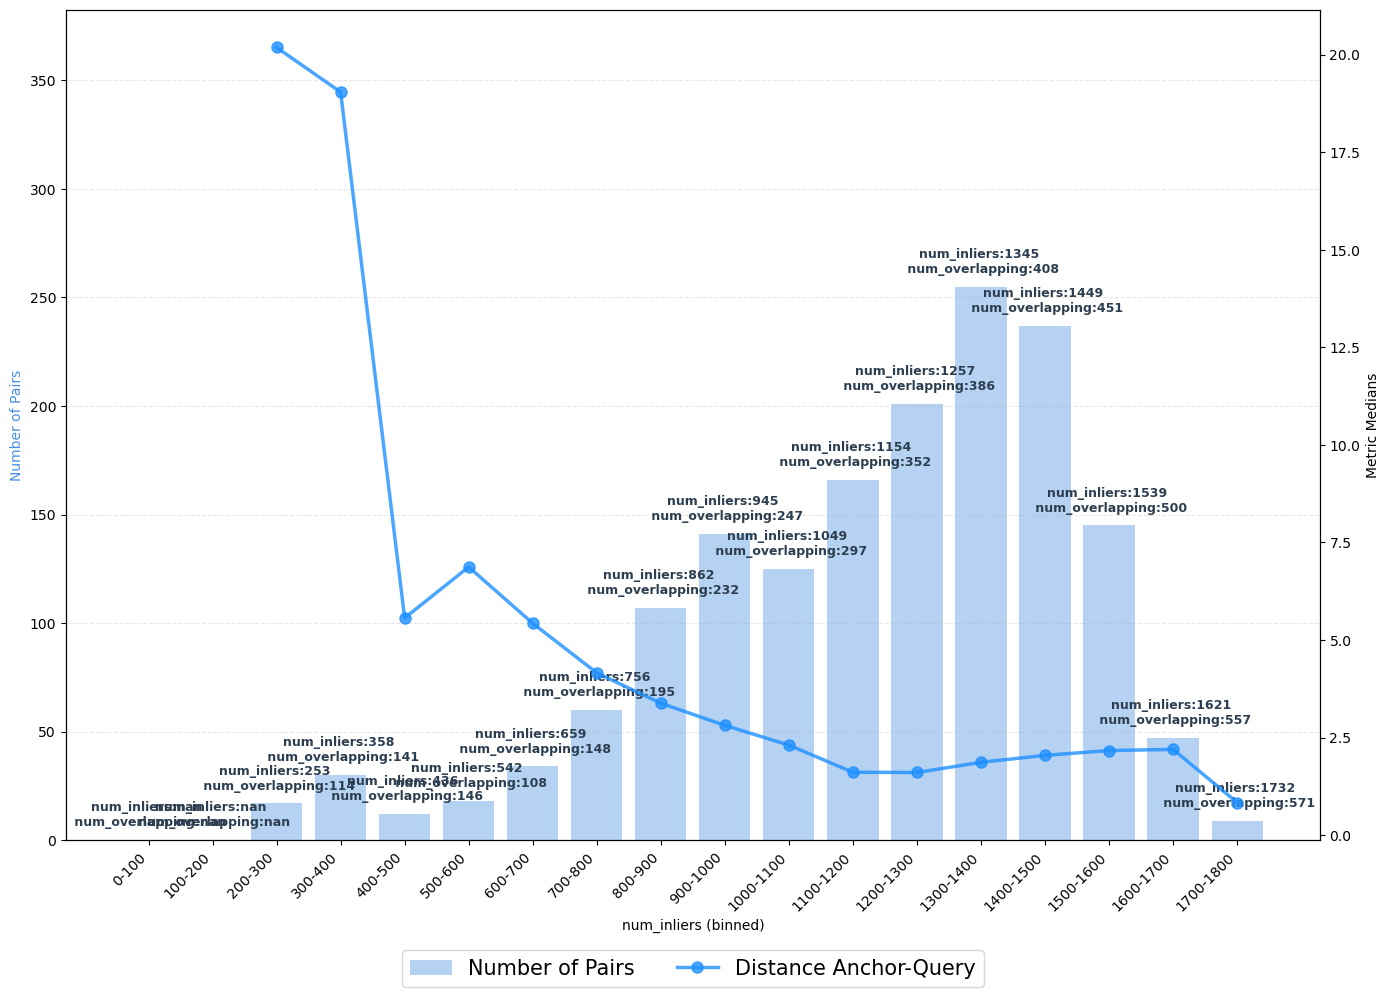

In [22]:
def plot_metrics_per_bin(dataset_to_plot, bin_by, metrics_to_plot, annotation_metrics, bin_min=None, bin_max=None):
    """
    Plot metrics per bin for a specific dataset, including bar plots for pair counts
    and line plots for metric medians, with optional custom bin limits.
    
    Args:
        dataset_to_plot: Name of the dataset to plot.
        bin_by: Column name to bin by (e.g., 'num_inliers' or 'num_matches').
        metrics_to_plot: Dictionary of metrics to plot with their configurations.
        annotation_metrics: List of metrics to annotate on the bar plot.
        bin_min: Minimum bin limit (default: None, uses data minimum).
        bin_max: Maximum bin limit (default: None, uses data maximum).
    """
    df = loaded_data[dataset_to_plot]
    df_ok = df[df['status'] == 'OK']

    # Determine bin limits
    data_min = df_ok[bin_by].min()
    data_max = df_ok[bin_by].max()
    bin_min = bin_min if bin_min is not None else 0
    bin_max = bin_max if bin_max is not None else int(data_max) + BIN_WIDTH

    # Create bins based on the selected binning column and custom limits
    bins = range(bin_min, bin_max, BIN_WIDTH)
    bin_column = f"{bin_by}_bin"
    df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)

    # Group by the bins and compute statistics
    grouped = df_ok.groupby(bin_column)
    count_by_bin = grouped.size()

    # Compute median for annotation metrics
    annotation_medians = {metric: grouped[metric].median() for metric in annotation_metrics if metric in df_ok.columns}

    # Compute median for each selected metric to plot
    metric_medians = {metric: grouped[metric].median() for metric in metrics_to_plot.keys() if metric in df_ok.columns}

    # Convert bin intervals to numeric values (midpoints)
    bin_midpoints = [interval.mid for interval in count_by_bin.index]

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(14, 10))

    # Bar plot: number of pairs per bin (left y-axis)
    bars = ax1.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=BIN_WIDTH * 0.8, alpha=0.4, label="Number of Pairs")
    ax1.set_ylabel("Number of Pairs", color="#4A90E2")
    ax1.set_xlabel(f"{bin_by} (binned)")
    ax1.set_xticks(bin_midpoints)
    ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], rotation=45, ha="right")
    ax1.set_ylim(0, max(count_by_bin) * 1.5)

    # Annotate bars with median values of selected metrics
    for i, bar in enumerate(bars):
        annotation_text = [f"{metric}:{annotation_medians[metric].iloc[i]:.0f}" for metric in annotation_metrics if metric in annotation_medians]
        if annotation_text:
            ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + max(count_by_bin) * 0.02, " \n ".join(annotation_text), ha="center", va="bottom", fontsize=9, color="#2C3E50", weight="bold")

    # Add line plots for metric medians (right y-axis)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Metric Medians", color="black")
    line_plots = []
    for metric, config in metrics_to_plot.items():
        if metric in metric_medians:
            line = ax2.plot(bin_midpoints, metric_medians[metric], 
                            color=config['color'], marker=config['marker'], 
                            label=config['label'], linewidth=2.5, markersize=8, alpha=0.8)
            line_plots.append((line[0], config['label']))

    # Combine legends
    legend_items = [(bars, "Number of Pairs")] + line_plots
    handles, labels = zip(*legend_items)
    ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=min(len(handles), 4), fontsize=15)

    # Add grid lines
    ax1.grid(axis="y", linestyle="--", alpha=0.3)

    # Dynamic title based on binning variable
    bin_label = "Matches" if bin_by == 'num_matches' else "Inliers"
    # plt.title(f"Metrics per {bin_label} Bin ({dataset_to_plot})", fontsize=14)
    plt.tight_layout()
    plt.show()
BIN_WIDTH=100
# Example usage with custom bin limits
plot_metrics_per_bin(
    dataset_to_plot='lidar',
    bin_by='num_inliers',
    metrics_to_plot={
        # 'x_error': {'color': '#FF4081', 'marker': 's', 'label': "Position Error"},
        'distance_anchor_query': {'color': '#1E90FF', 'marker': 'o', 'label': 'Distance Anchor-Query'},
    },
    annotation_metrics=['num_inliers', 'num_overlapping'],
    bin_min=None,  # Custom minimum bin limit
    bin_max=None  # Custom maximum bin limit
)



In [3]:



# Table 1: Success rate and num_inliers (median)
table1_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    table1_data.append({
        'method': pointcloud_type,
        'n_success': len(ok_pairs),
        'n_total': len(df),
        'success_rate': len(ok_pairs) / len(df) if len(df) > 0 else 0,
        'num_inliers_median': ok_pairs['num_inliers'].median() if len(ok_pairs) > 0 else np.nan
    })

table1 = pd.DataFrame(table1_data)
print("Table 1: Success Rates and Inliers")
print(table1)
print()

# Table 2: Position and rotation errors (median)
table2_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    table2_data.append({
        'method': pointcloud_type,
        'pos_error_median': ok_pairs['pos_error'].median() if len(ok_pairs) > 0 else np.nan,
        'x_error_median': ok_pairs['x_error'].median() if len(ok_pairs) > 0 else np.nan,
        'y_error_median': ok_pairs['y_error'].median() if len(ok_pairs) > 0 else np.nan,
        'z_error_median': ok_pairs['z_error'].median() if len(ok_pairs) > 0 else np.nan,
        'rot_error_median': ok_pairs['rot_error'].median() if len(ok_pairs) > 0 else np.nan
    })

table2 = pd.DataFrame(table2_data)
print("Table 2: Position and Rotation Errors (Median)")
print(table2.to_string(index=False))
print()

# Table 3: Distance and scales (mean and median)
table3_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    
    row = {
        'method': pointcloud_type,
        'distance_mean': ok_pairs['median_depth'].mean() if 'median_depth' in ok_pairs.columns and len(ok_pairs) > 0 else np.nan,
        'distance_median': ok_pairs['median_depth'].median() if 'median_depth' in ok_pairs.columns and len(ok_pairs) > 0 else np.nan,
    }
    
    # Add scale statistics
    if 'scale' in ok_pairs.columns:
        # row['scale_mean'] = ok_pairs['scale'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_median'] = ok_pairs['scale'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_x' in ok_pairs.columns:
        # row['scale_x_mean'] = ok_pairs['scale_x'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_x_median'] = ok_pairs['scale_x'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_y' in ok_pairs.columns:
        # row['scale_y_mean'] = ok_pairs['scale_y'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_y_median'] = ok_pairs['scale_y'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_z' in ok_pairs.columns:
        # row['scale_z_mean'] = ok_pairs['scale_z'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_z_median'] = ok_pairs['scale_z'].median() if len(ok_pairs) > 0 else np.nan
    
    table3_data.append(row)

table3 = pd.DataFrame(table3_data)
print("Table 3: Distance and Scale Statistics")
print(table3.to_string(index=False))

Table 1: Success Rates and Inliers
              method  n_success  n_total  success_rate  num_inliers_median
0             mast3r       1604     1605      0.999377              1253.0
1              lidar       1604     1605      0.999377              1253.0
2   mast3r_scaled_v3       1604     1605      0.999377              1253.0
3   mast3r_scaled_v4       1604     1605      0.999377              1253.0
4  mast3r_scaled_icp       1604     1605      0.999377              1253.0

Table 2: Position and Rotation Errors (Median)
           method  pos_error_median  x_error_median  y_error_median  z_error_median  rot_error_median
           mast3r          1.809801        0.224048        0.434700        1.323723          0.046201
            lidar          0.472759        0.047539        0.394418        0.085175          0.011069
 mast3r_scaled_v3          3.040096        0.362245        0.552869        2.628959          0.046351
 mast3r_scaled_v4          5.719569        0.961042        

In [7]:

# dataset_to_analyze = 'lidar'  
# target_bin_start = 800
# target_bin_end = 1000

# # Get the dataset
# df = loaded_data[dataset_to_analyze]
# df_ok = df[df['status'] == 'OK']

# # Filter for the specific match range
# matches_in_range = df_ok[(df_ok['num_matches'] >= target_bin_start) & (df_ok['num_matches'] < target_bin_end)]

# print(f"Pairs with {target_bin_start}-{target_bin_end} matches in {dataset_to_analyze}:")
# print(f"Number of pairs: {len(matches_in_range)}")
# print()

# # Show the indices and relevant information
# if len(matches_in_range) > 0:
#     relevant_cols = ['query_seq', 'anchor_seq', 'query_idx', 'anchor_idx','num_matches', 'num_overlapping', 'pos_error', 'distance_anchor_query', 'median_depth']
#     display_data = matches_in_range[relevant_cols].sort_values('pos_error', ascending=False)
    
#     print("Detailed breakdown:")
#     print(display_data.to_string(index=False))
    
#     # Summary statistics for this bin
#     print(f"\nSummary statistics for {target_bin_start}-{target_bin_end} matches bin:")
#     print(f"  Number of overlapping - Mean: {matches_in_range['distance_anchor_query'].mean():.1f}, Median: {matches_in_range['distance_anchor_query'].median():.1f}")
    
#     # # Show the specific query and anchor indices
#     # print(f"\nSpecific dataset indices:")
#     # for _, row in matches_in_range.iterrows():
#     #     print(f"  Query: seq={row['query_seq']}, idx={row['query_idx']} | Anchor: seq={row['anchor_seq']}, idx={row['anchor_idx']} | Matches: {row['num_matches']}")
# else:
#     print("No pairs found in this range")

Using lidar as reference for binning
Binning by: num_inliers
Comparing metric: pos_error
Total pairs in reference: 1605, Successful pairs: 1604


/tmp/ipykernel_46510/382686631.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_ok[bin_column] = pd.cut(df_ref_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_46510/382686631.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_46510/382686631.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

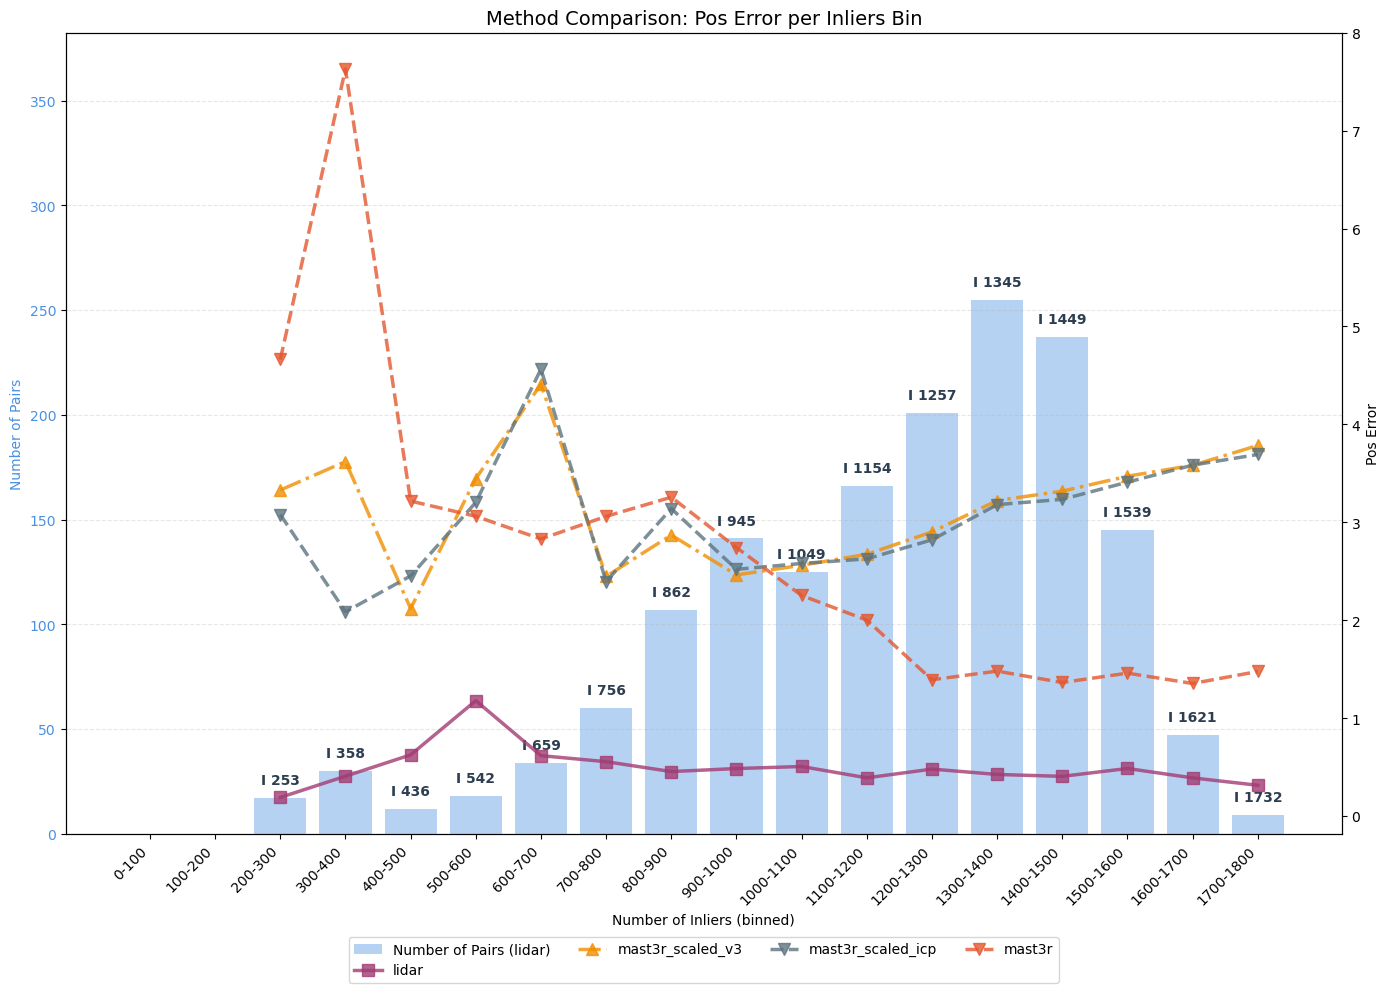


Comparison Statistics for pos_error:
lidar:
  Mean: 0.496
  Median: 0.468
  Min: 0.192
  Max: 1.180
mast3r_scaled_v3:
  Mean: 3.139
  Median: 3.271
  Min: 2.120
  Max: 4.411
mast3r_scaled_icp:
  Mean: 3.036
  Median: 3.110
  Min: 2.087
  Max: 4.565
mast3r:
  Mean: 2.703
  Median: 2.498
  Min: 1.355
  Max: 7.629


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Dynamic configuration
reference_dataset = 'lidar'  # Dataset to use for histogram/binning
bin_width = 100  # Adjust bin width as needed
bin_by = 'num_inliers'  # Change this to 'num_matches' or 'num_inliers'

# Choose which metric to compare across methods
metric_to_compare = 'pos_error'  # Change this to any metric you want to compare

# Choose which methods to compare (can select multiple)
methods_to_compare = {
    'lidar': {'color': '#A23B72', 'marker': 's', 'linestyle': '-'},            # Bright magenta
    'mast3r_scaled_v3': {'color': '#F18F01', 'marker': '^', 'linestyle': '-.'}, # Bright orange
    'mast3r_scaled_icp': {'color': '#5D737E', 'marker': 'v', 'linestyle': '--'}, # Bright teal
    'mast3r': {'color': '#E4572E', 'marker': 'v', 'linestyle': '--'}, # Bright red-orange
}

# Get the reference dataset for binning
df_ref = loaded_data[reference_dataset]
df_ref_ok = df_ref[df_ref['status'] == 'OK']

print(f"Using {reference_dataset} as reference for binning")
print(f"Binning by: {bin_by}")
print(f"Comparing metric: {metric_to_compare}")
print(f"Total pairs in reference: {len(df_ref)}, Successful pairs: {len(df_ref_ok)}")

# Validate binning column exists
if bin_by not in df_ref_ok.columns:
    raise ValueError(f"Error: Column '{bin_by}' not found in reference dataset!")

# Create bins based on reference dataset and selected binning column
bins = range(0, int(df_ref_ok[bin_by].max()) + bin_width, bin_width)
bin_column = f"{bin_by}_bin"
df_ref_ok[bin_column] = pd.cut(df_ref_ok[bin_by], bins=bins, right=False)

# Group reference data for histogram
grouped_ref = df_ref_ok.groupby(bin_column)
count_by_bin = grouped_ref.size()
median_inliers_by_bin = grouped_ref["num_inliers"].median()

# Convert bin intervals to numeric values (midpoints)
bin_midpoints = [interval.mid for interval in count_by_bin.index]

# Prepare data for all methods
method_data = {}
for method_name, config in methods_to_compare.items():
    if method_name in loaded_data:
        df = loaded_data[method_name]
        df_ok = df[df['status'] == 'OK']
        
        # Apply the same binning to this method's data
        df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
        grouped = df_ok.groupby(bin_column)
        
        # Compute the metric for this method
        if metric_to_compare in df_ok.columns:
            metric_values = grouped[metric_to_compare].median()
            # Reindex to match the reference bins (fill missing bins with NaN)
            metric_values = metric_values.reindex(count_by_bin.index)
            method_data[method_name] = metric_values
        else:
            print(f"Warning: {metric_to_compare} not found in {method_name}")

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 10))

# Bar plot: number of pairs per bin from reference dataset (left y-axis)
bars = ax1.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=bin_width * 0.8, alpha=0.4, 
               label=f"Number of Pairs ({reference_dataset})")
ax1.set_ylabel("Number of Pairs", color="#4A90E2")
ax1.tick_params(axis="y", labelcolor="#4A90E2")

# Dynamic x-axis label based on binning variable
x_label = "Number of Matches (binned)" if bin_by == 'num_matches' else "Number of Inliers (binned)"
ax1.set_xlabel(x_label)
ax1.set_xticks(bin_midpoints)
ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], 
                    rotation=45, ha="right")
ax1.set_ylim(0, max(count_by_bin) * 1.5)

# Annotate bars with median inliers from reference dataset
for i, (bar, median_inliers) in enumerate(zip(bars, median_inliers_by_bin)):
    if not pd.isna(median_inliers):
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(count_by_bin) * 0.02,
            f"I {median_inliers:.0f}",
            ha="center", va="bottom", fontsize=10, color="#2C3E50", weight="bold"
        )

# Create secondary y-axis for the metric comparison
ax2 = ax1.twinx()
ax2.set_ylabel(f"{metric_to_compare.replace('_', ' ').title()}", color="black")

# Plot the metric for each method
line_plots = []
for method_name, config in methods_to_compare.items():
    if method_name in method_data:
        line = ax2.plot(bin_midpoints, method_data[method_name], 
                       color=config['color'], marker=config['marker'], 
                       linestyle=config['linestyle'], label=method_name,
                       linewidth=2.5, markersize=8, alpha=0.8)
        line_plots.append((line[0], method_name))

# Combine legends
legend_items = [(bars, f"Number of Pairs ({reference_dataset})")] + line_plots
handles, labels = zip(*legend_items)
ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), 
          ncol=min(len(handles), 4), fontsize=10)

# Add grid lines
ax1.grid(axis="y", linestyle="--", alpha=0.3)

# Dynamic title based on binning variable
bin_label = "Matches" if bin_by == 'num_matches' else "Inliers"
plt.title(f"Method Comparison: {metric_to_compare.replace('_', ' ').title()} per {bin_label} Bin", fontsize=14)
plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\nComparison Statistics for {metric_to_compare}:")
print("=" * 50)
for method_name in methods_to_compare.keys():
    if method_name in method_data:
        values = method_data[method_name].dropna()
        if len(values) > 0:
            print(f"{method_name}:")
            print(f"  Mean: {values.mean():.3f}")
            print(f"  Median: {values.median():.3f}")
            print(f"  Min: {values.min():.3f}")
            print(f"  Max: {values.max():.3f}")
        else:
            print(f"{method_name}: No data available")
    else:
        print(f"{method_name}: Not loaded")

Using lidar as reference for binning
Binning by: num_inliers
Comparing metric: pos_error
Total pairs in reference: 1605, Successful pairs: 1604


/tmp/ipykernel_46510/2686547065.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_ok[bin_column] = pd.cut(df_ref_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_46510/2686547065.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)


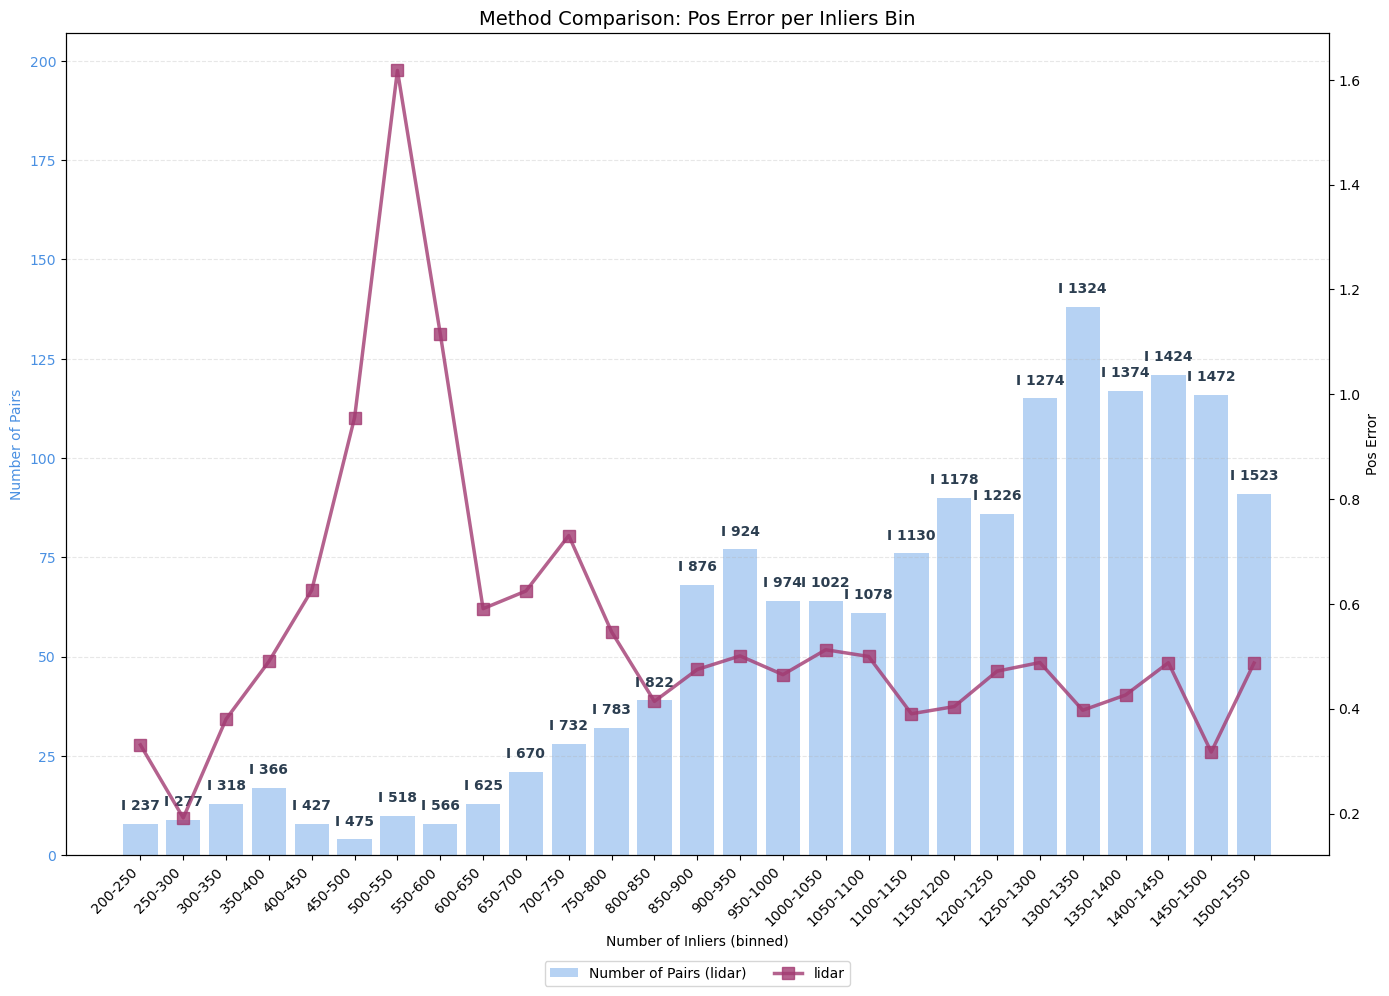


Comparison Statistics for pos_error:
lidar:
  Mean: 0.553
  Median: 0.488
  Min: 0.192
  Max: 1.618


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Dynamic configuration
reference_dataset = 'lidar'  # Dataset to use for histogram/binning
bin_width = 50  # Adjust bin width as needed
bin_by = 'num_inliers'  # Change this to 'num_matches' or 'num_inliers'

# Custom bin limits (set to None for default behavior)
bin_min = 200  # Minimum bin limit (set to None for default)
bin_max = 1600  # Maximum bin limit (set to None for default)

# Choose which metric to compare across methods
metric_to_compare = 'pos_error'  # Change this to any metric you want to compare

# Choose which methods to compare (can select multiple)
methods_to_compare = {
    'lidar': {'color': '#A23B72', 'marker': 's', 'linestyle': '-'},            # Bright magenta
    # 'mast3r_scaled_v3': {'color': '#F18F01', 'marker': '^', 'linestyle': '-.'}, # Bright orange
    # 'mast3r_scaled_icp': {'color': '#5D737E', 'marker': 'v', 'linestyle': '--'}, # Bright teal
}

# Get the reference dataset for binning
df_ref = loaded_data[reference_dataset]
df_ref_ok = df_ref[df_ref['status'] == 'OK']

print(f"Using {reference_dataset} as reference for binning")
print(f"Binning by: {bin_by}")
print(f"Comparing metric: {metric_to_compare}")
print(f"Total pairs in reference: {len(df_ref)}, Successful pairs: {len(df_ref_ok)}")

# Validate binning column exists
if bin_by not in df_ref_ok.columns:
    raise ValueError(f"Error: Column '{bin_by}' not found in reference dataset!")

# Determine bin limits
data_min = df_ref_ok[bin_by].min()
data_max = df_ref_ok[bin_by].max()
bin_min = bin_min if bin_min is not None else 0
bin_max = bin_max if bin_max is not None else int(data_max) + bin_width

# Create bins based on reference dataset and selected binning column
bins = range(bin_min, bin_max, bin_width)
bin_column = f"{bin_by}_bin"
df_ref_ok[bin_column] = pd.cut(df_ref_ok[bin_by], bins=bins, right=False)

# Group reference data for histogram
grouped_ref = df_ref_ok.groupby(bin_column)
count_by_bin = grouped_ref.size()
median_inliers_by_bin = grouped_ref["num_inliers"].median()

# Convert bin intervals to numeric values (midpoints)
bin_midpoints = [interval.mid for interval in count_by_bin.index]

# Prepare data for all methods
method_data = {}
for method_name, config in methods_to_compare.items():
    if method_name in loaded_data:
        df = loaded_data[method_name]
        df_ok = df[df['status'] == 'OK']
        
        # Apply the same binning to this method's data
        df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
        grouped = df_ok.groupby(bin_column)
        
        # Compute the metric for this method
        if metric_to_compare in df_ok.columns:
            metric_values = grouped[metric_to_compare].median()
            # Reindex to match the reference bins (fill missing bins with NaN)
            metric_values = metric_values.reindex(count_by_bin.index)
            method_data[method_name] = metric_values
        else:
            print(f"Warning: {metric_to_compare} not found in {method_name}")

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 10))

# Bar plot: number of pairs per bin from reference dataset (left y-axis)
bars = ax1.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=bin_width * 0.8, alpha=0.4, 
               label=f"Number of Pairs ({reference_dataset})")
ax1.set_ylabel("Number of Pairs", color="#4A90E2")
ax1.tick_params(axis="y", labelcolor="#4A90E2")

# Dynamic x-axis label based on binning variable
x_label = "Number of Matches (binned)" if bin_by == 'num_matches' else "Number of Inliers (binned)"
ax1.set_xlabel(x_label)
ax1.set_xticks(bin_midpoints)
ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], 
                    rotation=45, ha="right")
ax1.set_ylim(0, max(count_by_bin) * 1.5)

# Annotate bars with median inliers from reference dataset
for i, (bar, median_inliers) in enumerate(zip(bars, median_inliers_by_bin)):
    if not pd.isna(median_inliers):
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(count_by_bin) * 0.02,
            f"I {median_inliers:.0f}",
            ha="center", va="bottom", fontsize=10, color="#2C3E50", weight="bold"
        )

# Create secondary y-axis for the metric comparison
ax2 = ax1.twinx()
ax2.set_ylabel(f"{metric_to_compare.replace('_', ' ').title()}", color="black")

# Plot the metric for each method
line_plots = []
for method_name, config in methods_to_compare.items():
    if method_name in method_data:
        line = ax2.plot(bin_midpoints, method_data[method_name], 
                       color=config['color'], marker=config['marker'], 
                       linestyle=config['linestyle'], label=method_name,
                       linewidth=2.5, markersize=8, alpha=0.8)
        line_plots.append((line[0], method_name))

# Combine legends
legend_items = [(bars, f"Number of Pairs ({reference_dataset})")] + line_plots
handles, labels = zip(*legend_items)
ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), 
          ncol=min(len(handles), 4), fontsize=10)

# Add grid lines
ax1.grid(axis="y", linestyle="--", alpha=0.3)

# Dynamic title based on binning variable
bin_label = "Matches" if bin_by == 'num_matches' else "Inliers"
plt.title(f"Method Comparison: {metric_to_compare.replace('_', ' ').title()} per {bin_label} Bin", fontsize=14)
plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\nComparison Statistics for {metric_to_compare}:")
print("=" * 50)
for method_name in methods_to_compare.keys():
    if method_name in method_data:
        values = method_data[method_name].dropna()
        if len(values) > 0:
            print(f"{method_name}:")
            print(f"  Mean: {values.mean():.3f}")
            print(f"  Median: {values.median():.3f}")
            print(f"  Min: {values.min():.3f}")
            print(f"  Max: {values.max():.3f}")
        else:
            print(f"{method_name}: No data available")
    else:
        print(f"{method_name}: Not loaded")

In [19]:
import pandas as pd
import numpy as np

# Configuration
dataset_to_analyze = 'lidar'
num_top_pairs = 100  # Number of top pairs to analyze

# Get the dataset
df = loaded_data[dataset_to_analyze]
df_ok = df[df['status'] == 'OK']

# Sort by pos_error in descending order
df_sorted = df_ok.sort_values('y_error', ascending=False)

# Select the top N pairs
top_pairs = df_sorted.head(num_top_pairs)

print(f"Top {num_top_pairs} pairs with highest pos_error in {dataset_to_analyze}:")
print(top_pairs.to_string())

Top 100 pairs with highest pos_error in lidar:
      query_idx  anchor_idx  num_matches  num_inliers  num_overlapping  median_depth   x_error   y_error   z_error  pos_error  rot_error  distance_anchor_query status
1051    20088.0     10150.0       1857.0       1575.0            547.0      8.666224  0.048223  4.234344  0.016638   4.234651   0.029767               4.342698     OK
1049    20068.0     10140.0       1907.0       1412.0            495.0     10.165079  0.095231  4.228044  0.132363   4.231187   0.028486               5.009800     OK
1050    20088.0     10140.0       1575.0       1174.0            439.0     10.190579  0.039596  4.226552  0.135419   4.228907   0.030377               4.279466     OK
1048    20068.0     10130.0       1958.0       1479.0            516.0     10.493191  0.071729  4.225195  0.008345   4.225812   0.028129               4.355205     OK
1047    20068.0     10120.0       1675.0       1378.0            506.0     13.130806  0.026625  4.218701  0.039813   4

In [20]:
import pandas as pd
import numpy as np

# Configuration
dataset_to_analyze = 'lidar'
min_inliers = 500
max_inliers = 600

# Get the dataset
df = loaded_data[dataset_to_analyze]
df_ok = df[df['status'] == 'OK']

# Filter by number of inliers
df_filtered = df_ok[(df_ok['num_inliers'] >= min_inliers) & (df_ok['num_inliers'] <= max_inliers)]

# Sort by pos_error in descending order
df_sorted = df_filtered.sort_values('pos_error', ascending=False)

# Print the results
print(f"Pairs with {min_inliers}-{max_inliers} inliers in {dataset_to_analyze}, sorted by pos_error:")
print(df_sorted.to_string())

Pairs with 500-600 inliers in lidar, sorted by pos_error:
      query_idx  anchor_idx  num_matches  num_inliers  num_overlapping  median_depth   x_error   y_error   z_error  pos_error  rot_error  distance_anchor_query status
1055    20108.0     10150.0        901.0        550.0            212.0      9.899823  0.083088  4.158963  0.209828   4.165081   0.039679               4.719041     OK
947     18488.0      6970.0        643.0        508.0             92.0     71.918995  1.085578  2.614547  0.863709   2.959785   0.015516              12.857899     OK
949     18508.0      6980.0        648.0        505.0            107.0     69.215234  0.318499  2.309905  0.378084   2.362213   0.021887              15.323280     OK
951     18528.0      6990.0        694.0        527.0             98.0     66.329921  0.368676  2.128797  0.199928   2.169716   0.027707              16.420812     OK
946     18488.0      6980.0        772.0        539.0            108.0     69.201412  0.241858  2.008313  0